In [220]:
import data_base as db
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

## ВЫГРУЗКА ДАТАСЕТА ДЛЯ КЛАССИФИКАЦИИ (ОТКЛИКНЕТСЯ НА ПРЕДЛОЖЕНИЕ ИЛИ НЕТ)

In [512]:
connection, cursor = db.connect_db()
cursor.execute('''
SELECT
    pers_offer.customer_id,
    pers_offer.RESPONSE_DTTM,
    EXTRACT(DAY FROM MIN(pers_offer.RESPONSE_DTTM - bills.check_date ) )
FROM pers_offer LEFT JOIN (SELECT
                                bills.customer_id,
                                bills.check_date
                           FROM bills
                                GROUP BY 1,2)bills
                                ON (pers_offer.customer_id = bills.customer_id AND
                                bills.check_date < pers_offer.RESPONSE_DTTM)

GROUP BY 1,2

''')
result = cursor.fetchall()
db.close_connection(connection, cursor)
last_inc = pd.DataFrame(result,columns = ['customer_id',
                                                'RESPONSE_DTTM',
                                                'last_income'])

Database opened successfully


In [493]:
connection, cursor = db.connect_db()
cursor.execute('''
SELECT
    t.customer_id,
    t.campaign_type,
    t.offer_period,
    t.discount_type1,
    t.RESPONSE_DTTM,
    t.msg_text,
    t.h,
    t.doW,
    t.discount_amt,
    t.item2,
    t.Segment,
    t.holiday_weekday,
    t.sex,
    t.age,
    t.avg,
    t.last_income,
    products.product_direction_name,
    products.category_name,
    t.con
FROM
(SELECT
    t1.customer_id,
    t1.campaign_type,
    t1.offer_period,
    t1.discount_type1,
    t1.RESPONSE_DTTM,
    t1.msg_text,
    t1.h,
    t1.doW,
    t1.discount_amt,
    t1.item2,
    t3.Segment,
    t3.holiday_weekday,
    t3.sex,
    t3.age,
    t3.avg,
    EXTRACT(DAY FROM t3.last_income) last_income,
    t1.con
FROM 
(SELECT
    pers_offer.customer_id,
    pers_offer.campaign_type,
    (pers_offer.offer_end_dt - pers_offer.offer_start_dt) offer_period,
    pers_offer.discount_type1,
    pers_offer.RESPONSE_DTTM,
    substring(pers_offer.msg_text, '^[\w"%]*\s[\w!%-]*\s[^\wскидка|^\wСКИДКА]*') msg_text,
    EXTRACT( HOUR FROM (pers_offer.RESPONSE_DTTM)) h,
    EXTRACT( DOW FROM (pers_offer.RESPONSE_DTTM)) doW,
    pers_offer.discount_amt,
    substring(pers_offer.item2, '^\w\d+') item2,
    
    CASE
        WHEN
            billspromo.check_id LIKE '%'
        THEN
            1
        ELSE
            0
        END con

    FROM pers_offer LEFT JOIN (SELECT
                                    billspromo.check_id,
                                    billspromo.check_date,
                                    billspromo.customer_id,
                                    billspromo.promo_id
                                FROM
                                    billspromo
                                GROUP BY 1,2,3,4) billspromo
                                ON (billspromo.promo_id = pers_offer.promo_id 
                                AND billspromo.customer_id = pers_offer.customer_id 
                                AND billspromo.check_date BETWEEN pers_offer.offer_start_dt 
                        AND pers_offer.offer_end_dt)
WHERE pers_offer.campaign_type = 'PTB' 
    OR pers_offer.campaign_type = 'MBA' 
    OR pers_offer.campaign_type = 'Churn'
GROUP BY 1,2,3,4,5,6,7,8,9,10,11
    )t1 LEFT  JOIN (SELECT
                        t2.customer_id,
                        t2.Segment,
                        t2.holiday_weekday,
                        t2.sex,
                        t2.age,
                        bills.avg,
                        bills.last_income
                    FROM
                    (SELECT
                        clients_RFM.customer_id,
                        clients_RFM.Segment,
                        clients_RFM.holiday_weekday,
                        clients.sex,
                        clients.age
                    FROM
                        clients_RFM LEFT JOIN (SELECT
                                                clients.customer_id,
                                                clients.sex,
                                                clients.age
                                            FROM clients) clients
                                            ON (clients_RFM.customer_id = clients.customer_id)
                        ) t2 LEFT JOIN (SELECT
                                        bills.customer_id,
                                        AVG(bills.before_discount_amt) avg,
                                        MIN(TIMESTAMP '2020-03-01' - bills.check_date) last_income
                                    FROM bills
                                    GROUP BY 1)bills
                                    ON (t2.customer_id = bills.customer_id)
                        GROUP BY 1,2,3,4,5,6,7   
                        )t3
                        
                    ON (t3.customer_id = t1.customer_id)
GROUP BY 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
) t INNER JOIN (SELECT
                    products.category_cd,
                    products.group_cd,
                    products.subgroup_cd,
                    products.product_direction_name,
                    products.category_name
                FROM products) products
                ON (t.item2 = products.category_cd OR
                    t.item2 = products.group_cd OR
                    t.item2 = products.subgroup_cd)
GROUP BY 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
''')
result = cursor.fetchall()
db.close_connection(connection, cursor)
clients_draft = pd.DataFrame(result, columns = ['customer_id',
                                                'campaign_type',
                                                'offer_period',
                                                'discount_type1',
                                                'RESPONSE_DTTM',
                                                'msg_text',
                                                'msg_hour',
                                                'msg_dow',
                                                'discount_amt',
                                                'item2',
                                               'Segment',
                                                'holiday_weekday',
                                                'sex',
                                                'age',
                                               'avg_check',
                                               'last_income',
                                                'product_direction_name',
                                                'category_name',
                                                'conversion'])

Database opened successfully


In [516]:
clients_draft.drop('last_income',  axis='columns', inplace = True)
clients_draft = last_inc.merge(clients_draft, on=['RESPONSE_DTTM', 'customer_id'])
clients_draft.drop('RESPONSE_DTTM',  axis='columns', inplace = True)

In [519]:
clients_draft.to_csv('./clients_draft.csv',sep=';',index=False, header=True)
#clients_draft = pd.read_csv('./clients_draft.csv',sep=';')

In [610]:
clients_to_clsf.to_csv('./clients_to_clsf.csv',sep=';',index=False, header=True)

In [876]:
clients_to_clsf.to_csv('./newnew.csv',sep=';',index=False, header=True)

In [1234]:
clients_draft

,customer_id,last_income,campaign_type,offer_period,discount_type1,msg_text,msg_hour,msg_dow,discount_amt,item2,Segment,holiday_weekday,sex,age,avg_check,product_direction_name,category_name,conversion
0,00003187-2797-47f5-9ff1-5c2a3770c03c-ws,19.0,PTB,4,2,Для Вас,9.0,3.0,30.0,S11647,В зоне риска,БУДНИЙ,муж,24.0,365.105263,КРАСОТА,[уход за волосами]для волос,0
1,00003187-2797-47f5-9ff1-5c2a3770c03c-ws,27.0,Churn,6,2,Только вам -,13.0,6.0,30.0,S10534,В зоне риска,БУДНИЙ,муж,24.0,365.105263,КРАСОТА,[уход за волосами]для волос,0
2,0000431c-4744-4c82-bdca-0859de61566c-ws,13.0,PTB,4,2,Для Вас,14.0,4.0,15.0,C016,Постоянные клиенты,ВЫХОДНОЙ,муж,35.0,474.072727,ДЕКОР,[декоративная косметика],0
3,0000431c-4744-4c82-bdca-0859de61566c-ws,19.0,Churn,6,2,Только вам -,8.0,3.0,30.0,S10534,Постоянные клиенты,ВЫХОДНОЙ,муж,35.0,474.072727,КРАСОТА,[уход за волосами]для волос,0
4,0000431c-4744-4c82-bdca-0859de61566c-ws,10.0,PTB,4,2,Ваша СКИДКА,14.0,2.0,40.0,C016,Постоянные клиенты,ВЫХОДНОЙ,муж,35.0,474.072727,ДЕКОР,[декоративная косметика],0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1084148,ffff5bc2-927e-4426-aae4-2eacbb66b99e-ws,11.0,PTB,4,2,Для Вас,10.0,3.0,40.0,G1177,В зоне риска,ВЫХОДНОЙ,муж,46.0,539.457136,ЧИСТОТА,[средство гигиены],0
1084149,ffffafff-3029-4e7b-a5a1-a92adf226eb2-ws,28.0,PTB,2,2,Для Вас,8.0,2.0,25.0,C020,Бездействие,БУДНИЙ,жен,70.0,229.800000,КРАСОТА,для окраски волос,0
1084150,ffffc42c-ce8c-4fd9-b605-fe997bdc3707-ws,8.0,PTB,4,2,Ваша СКИДКА,11.0,6.0,40.0,C016,В зоне риска,БУДНИЙ,жен,25.0,124.666667,ДЕКОР,[декоративная косметика],0
1084151,ffffde29-7d94-4f5e-96e4-e1eb3260a3ef-ws,22.0,PTB,4,2,Для Вас,14.0,4.0,25.0,C019,Бездействие,БУДНИЙ,жен,27.0,222.744443,ЧИСТОТА,для обуви,0


In [521]:
clients_draft.groupby('conversion').size()

conversion
0    1031349
1      52804
dtype: int64

## ПОДГОТОВКА

In [42]:
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [776]:
clients_df = clients_draft.copy(deep=True)
clients_df = clients_df.dropna()
clients_df.sex.replace(['жен', 'муж'], [0, 1], inplace = True)
clients_df.holiday_weekday.replace(['БУДНИЙ', 'ВЫХОДНОЙ'], [0, 1], inplace = True)
clients_df.Segment.replace(['Бездействие',
                            'В зоне риска',
                           'Засыпающие',
                           'Постоянные клиенты',
                           'Чемпионы'], [0, 1, 2, 3, 4], inplace = True)

In [735]:
dummy_h = pd.get_dummies(clients_df['msg_hour'], prefix= 'hour', prefix_sep='_',)
dummy_camp = pd.get_dummies(clients_df['campaign_type'])
dummy_prod_dir = pd.get_dummies(clients_df['product_direction_name'])
dummy_products = pd.get_dummies(clients_df['category_name'])
dummy_Segment = pd.get_dummies(clients_df['Segment'])

In [799]:
clients_to_clsf = pd.concat([clients_df[['last_income',
                                         'offer_period',
                                         'discount_type1',
                                         'msg_dow',
                                         'discount_amt',
                                         'Segment',
                                         'holiday_weekday',
                                         'sex',
                                         'age',
                                         'avg_check',
                                         'offer_period']],
                             dummy_products,
                             dummy_h,
                             clients_df['conversion']],axis=1)

In [770]:
clients_df.columns

Index(['customer_id', 'last_income', 'campaign_type', 'offer_period',
       'discount_type1', 'msg_text', 'msg_hour', 'msg_dow', 'discount_amt',
       'item2', 'Segment', 'holiday_weekday', 'sex', 'age', 'avg_check',
       'product_direction_name', 'category_name', 'conversion'],
      dtype='object')

In [887]:
clients_to_clsf.shape

(188563, 56)

In [ ]:
new = clients_to_clsf.loc[clients_to_clsf['conversion']== 0][:105797]
new_n = pd.concat([new,clients_to_clsf.loc[clients_to_clsf['conversion']== 1]],axis=0)
clients_to_clsf = new_n

In [897]:
X = clients_to_clsf.iloc[:,:55]
Y = clients_to_clsf.iloc[:,55:]
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.33, random_state=42)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Дерево принятия решений

In [930]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier( max_depth = 4, random_state=42)
tree.fit(X_train, Y_train)
print("Правильность на обучающем наборе: {:.3f}".format(tree.score(X_train, Y_train)))
print("Правильность на тестовом наборе: {:.3f}".format(tree.score(X_test, Y_test)))

Правильность на обучающем наборе: 0.756
Правильность на тестовом наборе: 0.752


In [931]:
from sklearn.tree import export_graphviz
export_graphviz(tree, out_file="tree.dot", class_names=["0", "1"],
 feature_names=X.columns, impurity=False, filled=True)

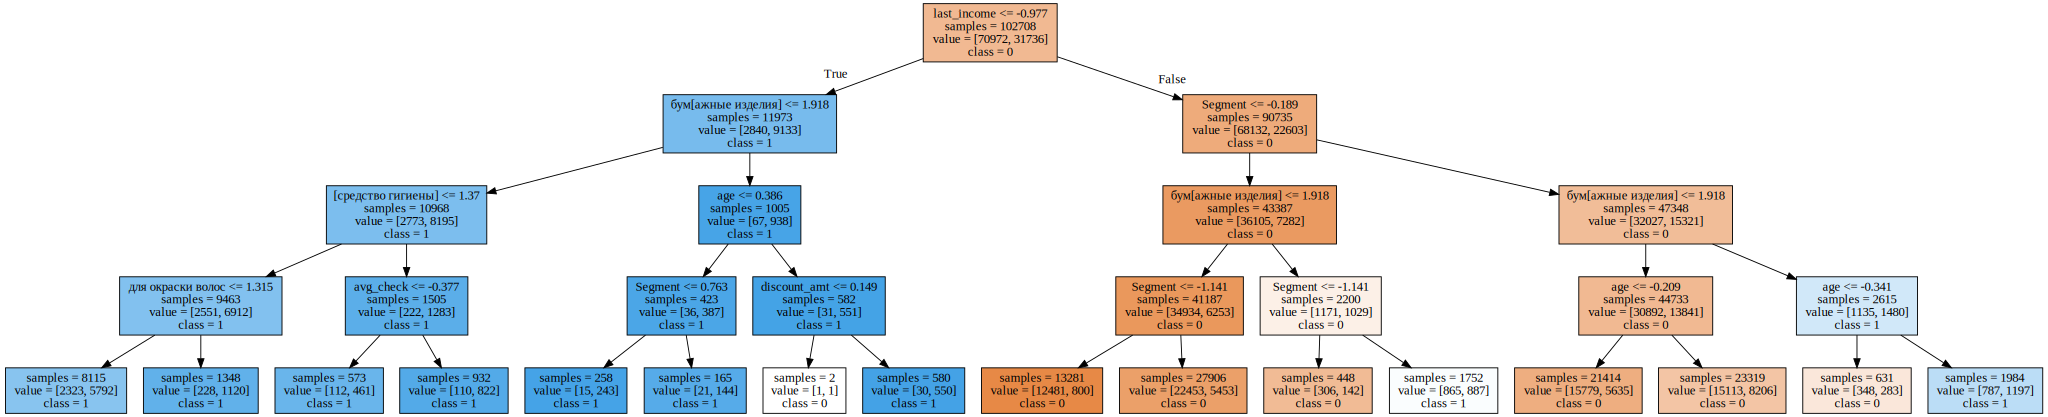

In [932]:
import graphviz

with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

In [953]:
y_pred_tree = tree.predict(X_test)
print('confusion_matrix\n', confusion_matrix(Y_test,y_pred_tree))
print(classification_report(Y_test, y_pred_tree))

confusion_matrix
 [[32576  2249]
 [10274  5490]]
              precision    recall  f1-score   support

           0       0.76      0.94      0.84     34825
           1       0.71      0.35      0.47     15764

    accuracy                           0.75     50589
   macro avg       0.73      0.64      0.65     50589
weighted avg       0.74      0.75      0.72     50589



In [995]:
from sklearn.naive_bayes import GaussianNB BernoulliNB

In [1025]:
gaus = BernoulliNB()
gaus.fit(X1_train,np.ravel(Y1_train))
Y1_pred = gaus.predict(X1_test)
print('confusion_matrix\n',confusion_matrix(Y1_test,Y1_pred))
print(classification_report(Y1_test,Y1_pred))
print(accuracy_score(Y1_test, Y1_pred))

confusion_matrix
 [[32229  2758]
 [ 9871  5731]]
              precision    recall  f1-score   support

         0.0       0.77      0.92      0.84     34987
         1.0       0.68      0.37      0.48     15602

    accuracy                           0.75     50589
   macro avg       0.72      0.64      0.66     50589
weighted avg       0.74      0.75      0.73     50589

0.7503607503607503


# Ансамбли

## Случайный лес

In [972]:
forest = RandomForestClassifier(
                                random_state=42)
forest.fit(X_train, np.ravel(Y_train))
Y_pred = forest.predict(X_test)
print(confusion_matrix(Y_test,Y_pred))
print(classification_report(Y_test,Y_pred))
print(accuracy_score(Y_test, Y_pred))

[[31130  3695]
 [ 8786  6978]]
              precision    recall  f1-score   support

           0       0.78      0.89      0.83     34825
           1       0.65      0.44      0.53     15764

    accuracy                           0.75     50589
   macro avg       0.72      0.67      0.68     50589
weighted avg       0.74      0.75      0.74     50589

0.7532862875328629


In [ ]:
clf = RandomForestClassifier(criterion='entropy', 
                             n_estimators=50,
                             min_samples_split=8,
                             min_samples_leaf=2,
                             max_features='auto',
                             oob_score=True,
                             random_state=0)
clf.fit(X_train, np.ravel(Y_train))
y_pred = clf.predict(X_test)
print(confusion_matrix(Y_test,y_pred))
print(classification_report(Y_test,y_pred))
print(accuracy_score(Y_test, y_pred))

### GB

In [1026]:
from sklearn.ensemble import GradientBoostingClassifier

In [1028]:
gbrt = GradientBoostingClassifier(random_state=42)
gbrt.fit(X_train, Y_train)
gbrt.fit(X_train, np.ravel(Y_train))
y_pred = gbrt.predict(X_test)
print(confusion_matrix(Y_test,y_pred))
print(classification_report(Y_test,y_pred))
print(accuracy_score(Y_test, y_pred))

[[32603  2222]
 [10045  5719]]
              precision    recall  f1-score   support

           0       0.76      0.94      0.84     34825
           1       0.72      0.36      0.48     15764

    accuracy                           0.76     50589
   macro avg       0.74      0.65      0.66     50589
weighted avg       0.75      0.76      0.73     50589

0.7575164561465931


In [ ]:
from xgboost.sklearn import XGBClassifier  

In [1058]:
model = XGBClassifier(n_estimators = 300,
                      max_depth = 5,
                      learning_rate = 0.2,
                      random_state = 42)
model.fit(X_train, np.ravel(Y_train))
Y_hat = model.predict(X_test)

print('confusion_matrix\n',confusion_matrix(Y_test,Y_hat))
print(classification_report(Y_test,Y_hat))

confusion_matrix
 [[31913  2912]
 [ 8804  6960]]
              precision    recall  f1-score   support

           0       0.78      0.92      0.84     34825
           1       0.71      0.44      0.54     15764

    accuracy                           0.77     50589
   macro avg       0.74      0.68      0.69     50589
weighted avg       0.76      0.77      0.75     50589



In [1032]:
import xgboost as xgb

In [1033]:
model = xgb.XGBClassifier()
model.fit(X_train, Y_train)
Y_hat = model.predict(X_test)
print(accuracy_score(Y_test, Y_hat))

print(confusion_matrix(Y_test,Y_hat))
print(classification_report(Y_test,Y_hat))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7657000533712862
[[31974  2851]
 [ 9002  6762]]
              precision    recall  f1-score   support

           0       0.78      0.92      0.84     34825
           1       0.70      0.43      0.53     15764

    accuracy                           0.77     50589
   macro avg       0.74      0.67      0.69     50589
weighted avg       0.76      0.77      0.75     50589



# ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ

In [1068]:
logreg = LogisticRegression(C=100).fit(X_train, Y_train)
y_pred_logreg = logreg.predict(X_test)
print(confusion_matrix(Y_test,y_pred_logreg))
print(classification_report(Y_test,y_pred_logreg))
print(accuracy_score(Y_test, y_pred_logreg))

[[31965  2860]
 [11557  4207]]
              precision    recall  f1-score   support

           0       0.73      0.92      0.82     34825
           1       0.60      0.27      0.37     15764

    accuracy                           0.72     50589
   macro avg       0.66      0.59      0.59     50589
weighted avg       0.69      0.72      0.68     50589

0.7150170985787424


# __ _ __ ___ ____ _ __ ___ ___ ______ ______  ___ ___ ____ _____ ____

In [1102]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(max_iter = 500,
                    learning_rate_init = 0.002,
                    random_state=42)
mlp.fit(X_train, np.ravel(Y_train))
y_mlp = mlp.predict(X_test)
print('confusion_matrix\n',confusion_matrix(Y_test,y_mlp))
print(classification_report(Y_test,y_mlp))

confusion_matrix
 [[31516  3309]
 [ 9008  6756]]
              precision    recall  f1-score   support

           0       0.78      0.90      0.84     34825
           1       0.67      0.43      0.52     15764

    accuracy                           0.76     50589
   macro avg       0.72      0.67      0.68     50589
weighted avg       0.74      0.76      0.74     50589



In [1103]:
from keras.models import Sequential 
from keras.layers import InputLayer 
from keras.layers import Dense 
from keras.layers import Dropout 
from keras.constraints import maxnorm

In [1358]:
model = Sequential()
model.add(Dense(512, input_dim=55, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(rate=0.2))
model.add(Dense(128, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(rate=0.2))
model.add(Dense(64, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(rate=0.2))
model.add(Dense(1, activation='sigmoid'))

In [1359]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adamax', metrics=['accuracy'])

In [1362]:
h = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=50, batch_size=1000)

Train on 102708 samples, validate on 50589 samples
Epoch 1/50
102708/102708 [==============================] - 2s 19us/step - loss: 0.5002 - accuracy: 0.7559 - val_loss: 0.5053 - val_accuracy: 0.7540
Epoch 2/50
102708/102708 [==============================] - 2s 19us/step - loss: 0.4986 - accuracy: 0.7560 - val_loss: 0.5039 - val_accuracy: 0.7543
Epoch 3/50
102708/102708 [==============================] - 2s 19us/step - loss: 0.4972 - accuracy: 0.7575 - val_loss: 0.5038 - val_accuracy: 0.7542
Epoch 4/50
102708/102708 [==============================] - 2s 19us/step - loss: 0.4968 - accuracy: 0.7574 - val_loss: 0.5037 - val_accuracy: 0.7551
Epoch 5/50
102708/102708 [==============================] - 2s 19us/step - loss: 0.4954 - accuracy: 0.7581 - val_loss: 0.5033 - val_accuracy: 0.7553
Epoch 6/50
102708/102708 [==============================] - 3s 30us/step - loss: 0.4944 - accuracy: 0.7578 - val_loss: 0.5038 - val_accuracy: 0.7554
Epoch 7/50
102708/102708 [=============================

In [1365]:
p_last_epoch = model.predict(X_test, verbose=1)
for i in range(0,len(p_last_epoch)):
    if p_last_epoch[i] <0.5:
        p_last_epoch[i] = 0
    else:
        p_last_epoch[i] = 1

50589/50589 [==============================] - 2s 34us/step


In [1312]:
print('confusion_matrix\n',confusion_matrix(Y_test,p_last_epoch))
print(classification_report(Y_test,p_last_epoch))

confusion_matrix
 [[31889  2936]
 [ 9003  6761]]
              precision    recall  f1-score   support

           0       0.78      0.92      0.84     34825
           1       0.70      0.43      0.53     15764

    accuracy                           0.76     50589
   macro avg       0.74      0.67      0.69     50589
weighted avg       0.75      0.76      0.75     50589



# __ _ __ ___ ____ _ __ ___ ___ ______ ______  ___ ___ ____ _____ ____

In [1178]:
model = Sequential()
model.add(Dense(64, input_dim=55, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(rate=0.2))
model.add(Dense(8, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(rate=0.2))
model.add(Dense(1, activation='sigmoid'))

In [1179]:
model.compile(loss = "binary_crossentropy", optimizer = 'adam', metrics=['accuracy'])

In [1180]:
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=20, batch_size=8)

Train on 102708 samples, validate on 50589 samples
Epoch 1/20
102708/102708 [==============================] - 22s 213us/step - loss: 0.5571 - accuracy: 0.7151 - val_loss: 0.5317 - val_accuracy: 0.7324
Epoch 2/20
102708/102708 [==============================] - 19s 188us/step - loss: 0.5331 - accuracy: 0.7355 - val_loss: 0.5220 - val_accuracy: 0.7424
Epoch 3/20
102708/102708 [==============================] - 22s 212us/step - loss: 0.5256 - accuracy: 0.7404 - val_loss: 0.5167 - val_accuracy: 0.7471
Epoch 4/20
102708/102708 [==============================] - 19s 186us/step - loss: 0.5219 - accuracy: 0.7432 - val_loss: 0.5145 - val_accuracy: 0.7477
Epoch 5/20
102708/102708 [==============================] - 18s 176us/step - loss: 0.5187 - accuracy: 0.7446 - val_loss: 0.5123 - val_accuracy: 0.7492
Epoch 6/20
102708/102708 [==============================] - 20s 192us/step - loss: 0.5173 - accuracy: 0.7471 - val_loss: 0.5127 - val_accuracy: 0.7476
Epoch 7/20
102708/102708 [=================

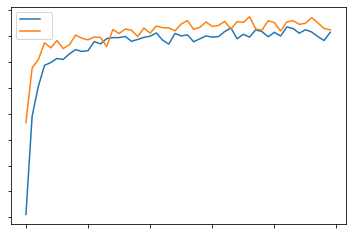

In [1131]:
plt.plot(history.history['accuracy']) 
plt.plot(history.history['val_accuracy']) 
plt.title('model accuracy') 
plt.ylabel('accuracy')
plt.xlabel('epoch') 
plt.legend(['train', 'test'], loc='upper left') 
plt.show()

In [1181]:
predictions_last_epoch = model.predict(X_test, verbose=1)

50589/50589 [==============================] - 1s 12us/step


In [1182]:
for i in range(0,len(predictions_last_epoch)):
    if predictions_last_epoch[i] <0.5:
        predictions_last_epoch[i] = 0
    else:
        predictions_last_epoch[i] = 1

In [1161]:
print('confusion_matrix\n',confusion_matrix(Y_test,predictions_last_epoch))
print(classification_report(Y_test,predictions_last_epoch))

confusion_matrix
 [[31990  2835]
 [ 9750  6014]]
              precision    recall  f1-score   support

           0       0.77      0.92      0.84     34825
           1       0.68      0.38      0.49     15764

    accuracy                           0.75     50589
   macro avg       0.72      0.65      0.66     50589
weighted avg       0.74      0.75      0.73     50589

